In [1]:
from pydicom import dcmread
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from skimage.filters import unsharp_mask
from natsort import natsorted
from skimage.exposure import match_histograms
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy.optimize import dual_annealing,fmin_powell
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *
import h5py

In [2]:
# path = f'data/'
# # path = 'intervolume_registered/self_inter/scan5/'
# pic_paths = []
# for i in os.listdir(path):
#     if i.endswith('.h5'):
#         pic_paths.append(i)
# with h5py.File(path+pic_paths[0], 'r') as hf:
#     original_data = np.array(hf['volume'][:,150:650,:])

# # original_data = original_data[:,150:650,:]
def load_data_dcm(path_num,path_all = False):
    path = path_num
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)
    temp_img = dcmread(path+pic_paths[0]).pixel_array
    imgs_from_folder = np.zeros((len(pic_paths),*temp_img.shape))
    for i,j in enumerate(pic_paths):
        aa = dcmread(path+j)
        imgs_from_folder[i] = aa.pixel_array
    imgs_from_folder = imgs_from_folder.astype(np.float32)
    return imgs_from_folder

In [3]:
original_data = load_data_dcm('data/')
original_data = original_data[:,np.r_[200:500,1500:2250],:]

In [5]:
main_final_transform = transforms_all = np.tile(np.eye(3),(original_data.shape[0],1,1))

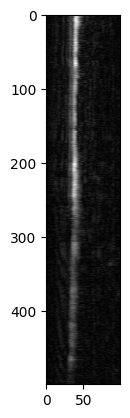

In [10]:
plt.imshow(original_data[:,800:900,91],cmap='gray')

# Flat only self

In [11]:
UP,DOWN = 800,900
static_flat = np.argmax(np.sum(original_data[:,UP:DOWN,:],axis=(0,1)))
static_flat

np.int64(123)

In [12]:

def mse_fun_tran_flat(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(-past_shift,0)),order=1)
    y = warp(y, AffineTransform(translation=(past_shift,0)),order=1)

    warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)),order=1)
    warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)),order=1)

    return (1-ncc(warped_x_stat ,warped_y_mov))
    
def ants_all_tran_flat(data,UP,DOWN,static_flat):
    transforms_all = np.tile(np.eye(3),(data.shape[2],1,1))
    for i in tqdm(range(data.shape[2]),desc='tr_all'):
        stat = data[:,UP:DOWN,static_flat][::20].copy()
        temp_img = data[:,UP:DOWN,i][::20].copy()

        # MANUAL
        # temp_tform_manual = AffineTransform(translation=(0,0))
        past_shift = 0
        for _ in range(10):
            move = minz(method='powell',fun = mse_fun_tran_flat,x0 =(0), bounds=[(-3,3)],
                        args = (stat
                                ,temp_img
                                ,past_shift))['x']

            past_shift += move[0]
        temp_tform_manual = AffineTransform(translation=(past_shift*2,0))
        transforms_all[i] = np.dot(transforms_all[i],temp_tform_manual)

    return transforms_all


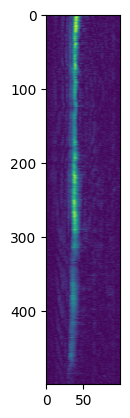

In [13]:
plt.imshow(original_data[:,UP:DOWN,static_flat])

In [ ]:
n = original_data.shape[1]

# finding the bright points in all images in standard interference
temp_rotated_data = original_data[:,UP:DOWN,:].transpose(2,1,0)
nn = [np.argmax(np.sum(temp_rotated_data[i],axis=1)) for i in range(temp_rotated_data.shape[0])]
tf_all_nn = np.tile(np.eye(3),(temp_rotated_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(-(nn[0]-nn[i]),0)))
for i in tqdm(range(original_data.shape[2]),desc='warping'):
    original_data[:,UP:DOWN,i]  = warp(original_data[:,UP:DOWN,i] ,AffineTransform(matrix=tf_all_nn[i]),order=3)